In [7]:
import os.path
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras import regularizers
from sklearn.model_selection import train_test_split
import zipfile
import uuid
import random
from sklearn.metrics import roc_auc_score

In [8]:
class Data():
    def __init__(self, data_path = 'Data/SouthGermanCredit/', german = 'SouthGermanCredit.asc', english = 'SouthGermanCredit_english.csv'):
        self.data_path = data_path
        self.german = german
        self.english = english
        if not os.path.isfile(self.data_path + english):
            self.translate()
            
    def translate(self):
        df = pd.read_csv(self.data_path + self.german, sep = ' ')
        df.rename(columns = {
                            'laufkont': 'status', 
                            'laufzeit': 'duration',
                            'moral': 'credit_history',
                            'verw': 'purpose',
                            'hoehe': 'amount',
                            'sparkont': 'savings',
                            'beszeit': 'employment_duration',
                            'rate': 'installment_rate',
                            'famges': 'personal_status_sex',
                            'buerge': 'other_debtors',
                            'wohnzeit': 'present_residence',
                            'verm': 'property',
                            'alter': 'age',
                            'weitkred': 'other_installment_plans',
                            'wohn': 'housing',
                            'bishkred': 'number_credits',
                            'beruf': 'job',
                            'pers': 'people_liable',
                            'telef': 'telephone',
                            'gastarb': 'foreign_worker',
                            'kredit': 'credit_risk'
                            }, inplace = True)
        df.to_csv(self.data_path + self.english, index = False)
    
    def view_data(self):
        df = pd.read_csv(self.data_path + self.english)
        print(df.columns)
        print(df.describe())
        print(df.head())
        
    def get_data(self):
        return pd.read_csv(self.data_path + self.english).astype(np.float32)
    
    def gen_uuid(self, df, uuid_list = []):
        for i in range(df.shape[0]):
            uuid_list.append(str(uuid.uuid4()))
        uuid_list = pd.Series(uuid_list)
        df_uuid = df.copy()
        df_uuid['id'] = uuid_list
        df_uuid = df_uuid.set_index('id')
        return df_uuid
    
    def get_data_vfl(self, df, display = False):
        common = ['credit_history', 'age', 'employment_duration', 'amount', 'savings', 'number_credits']
        
        data_1 = ['purpose', 'personal_status_sex',
                  'present_residence', 'housing', 'job', 'telephone', 'foreign_worker']
        
        # has label [credit_risk]
        data_2 = ['status', 'duration', 'installment_rate', 'other_debtors',
                  'property', 'other_installment_plans', 'people_liable', 'credit_risk']
        
        if (common):
            data_1.extend(common)
            data_2.extend(common)
            
        if (display):
            print(df[data_1].head())
            print('----------------------')
            print(df[data_2].head())
        return df[data_1], df[data_2]

In [9]:
class Helpers():
    def __init__(self):
        pass
    def plot_loss(self, loss, accuracy):
        plt.plot(loss, label='loss')
        plt.plot(accuracy, label='accuracy')
        plt.xlabel('Epoch')
        # plt.ylabel('Error')
        plt.legend()
        plt.grid(True)

    def plot_accuracy(self, predictions, answers):
        tp, tn, fp, fn = 0, 0, 0, 0

        for x in range(len(predictions)):
            if answers[x] == 1:
                if np.argmax(predictions[x]) == 1:
                    tp = tp + 1
                else:
                    fn = fn + 1
            else:
                if np.argmax(predictions[x]) == 0:
                    tn = tn + 1
                else:
                    fp = fp + 1

        accuracy = (tp + tn)/(tp + fp + fn + tn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)
        print("Accuracy: " + str(accuracy))
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        # print("Specificity: " + str(specificity))
        print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))


    def convert_to_non_sparse(self, sparse):
        vector_list = np.zeros((len(sparse), 2))
        for x in range(len(sparse)):
            vector_list[x] = [1 - sparse[x], sparse[x]]
        return vector_list

In [10]:
data_class = Data()
original_df = data_class.get_data()
df_id = data_class.gen_uuid(original_df)
df_1, df_2 = data_class.get_data_vfl(df_id)
df_1_train, df_1_test = train_test_split(df_1, test_size = 0.2, random_state = 69)
df_2_train, df_2_test = df_2.loc[df_1_train.index], df_2.loc[df_1_test.index]

common_train_id = df_1_train.index.intersection(df_2_t        print(data_1)
        print(data_2)rain.index)
common_test_id = df_1_test.index.intersection(df_2_test.index)
common_train_id_list = common_train_id.to_list()

In [11]:
batch_size = 32
learning_rate = 1e-3
epochs = 50

optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = False)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [12]:
class Client():
    def __init__(self, train, test, labelled):
        self.__trainX = train.copy()
        self.__testX = test.copy()
        self.labelled = labelled
        
        if (labelled):
            self.__trainY = self.__trainX.pop('credit_risk')
            self.__testY = self.__testX.pop('credit_risk')
        
        normalizer = preprocessing.Normalization()
        normalizer.adapt(np.array(self.__trainX.loc[common_train_id]))

        self.model = tf.keras.Sequential([
              normalizer,
              layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
              layers.Dropout(0.5),
              layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
              layers.Dropout(0.5),
              layers.Dense(2),
              layers.Softmax()])
        
    def next_batch(self, index):
        self.batchX = self.__trainX.loc[index]
        if not self.labelled:
            grads = []
            self.model_output = np.zeros((len(index), 2))
            for i in range(len(index)):
                with tf.GradientTape() as gt:
                    gt.watch(self.model.trainable_weights)
                    output_by_example = self.model(self.batchX.iloc[i:i+1], training = True)
                    output_for_grad = output_by_example[:,1]
                self.model_output[i] = output_by_example
                grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))
            return grads
        else:
            self.batchY = self.__trainY.loc[index]
            with tf.GradientTape() as self.gt:
                self.gt.watch(self.model.trainable_weights)
                self.model_output = self.model(self.batchX, training = True)

    def cal_model(self):
        return self.model_output
  
    def predict(self, test_index):
        return self.model.predict(self.__testX.loc[test_index])# + 1e-8

    def test_answers(self, test_index):
        if self.labelled:
            return self.__testY.loc[test_index]
  
    def batch_answers(self):
        if self.labelled:
            return self.batchY

    def loss_and_update(self, a):
        if not self.labelled:
            raise AssertionError("This method can only be called by client 2")
        self.prob = (a + self.model_output)/2
        self.c = self.coefficient_and_update()/len(self.batchX)
        return self.prob, loss_fn(self.batchY, self.prob)
  
    def coefficient_and_update(self):
        if not self.labelled:
            raise AssertionError("This method can only be called by client 2")
        p = self.prob[:,1]
        c = (p-self.batchY)/((p)*(1-p))
        with self.gt:
            output = sum(c * self.model_output[:,1])/len(c)
        grads = self.gt.gradient(output, self.model.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return c
  
    def update_with(self, grads):
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

    def assemble_grad(self, partial_grads):
        if not self.labelled:
            raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
        for i in range(len(self.c)):
            partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
        return [sum(x) for x in zip(*partial_grads)]

In [13]:
client1 = Client(df_1_train, df_1_test, False)
client2 = Client(df_2_train, df_2_test, True)

In [14]:
epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
    random.shuffle(common_train_id_list)
    train_id_batches = [common_train_id_list[i:i + batch_size] for i in range(0, len(common_train_id_list), batch_size)] 
    total_loss = 0.0
    # Iterate over the batches of the dataset.
    for step, batch_index in enumerate(train_id_batches):
    
        partial_grads = client1.next_batch(batch_index)
        client2.next_batch(batch_index)

        prob, loss_value = client2.loss_and_update(client1.cal_model())
        grad = client2.assemble_grad(partial_grads)
        client1.update_with(grad)

        total_loss = loss_value + total_loss
        train_acc_metric.update_state(client2.batch_answers(), prob)
  
    train_acc = train_acc_metric.result()
    train_acc_metric.reset_states()
    epoch_loss.append((total_loss)/(step + 1))
    epoch_acc.append(train_acc)

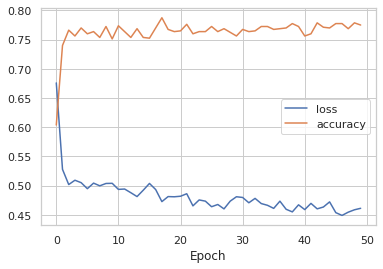

In [15]:
helpers = Helpers()
helpers.plot_loss(epoch_loss, epoch_acc)

In [16]:
predictions = (client1.predict(common_test_id) + client2.predict(common_test_id))/2
# predictions and answers are already aligned
helpers.plot_accuracy(predictions, client2.test_answers(common_test_id))

print("AUC: {}".format(roc_auc_score(client2.test_answers(common_test_id), predictions[:,1])))

Accuracy: 0.75
Precision: 0.7664670658682635
Recall: 0.920863309352518
F-Measure: 0.8366013071895425
AUC: 0.7565750678146008
